# Import libraries

In [1]:
using Pkg

using Flux, MLDataPattern, Mill, JsonGrinder, JSON, Statistics, IterTools, StatsBase, ThreadTools
using JsonGrinder: suggestextractor, ExtractDict
using Mill: reflectinmodel
using CSV, DataFrames
using Random
using Dates
using Plots
using Printf

In [2]:
THREADS = Threads.nthreads() 

1

# Import data

In [3]:
PATH_BEN_REPORTS = "../data/dataset1/ben_static/"
PATH_MAL_REPORTS = "../data/dataset1/mal_static/"
PATH_TO_LABELS = "../data/dataset1/labels_static.csv" ;

In [4]:
df=CSV.read(PATH_TO_LABELS,DataFrame);

df_labels_ben=filter("label" => x -> x == 0,df)[1:1000,:]
df_labels_mal=filter("label" => x -> x == 1,df)[1:1000,:]

df_labels=vcat(df_labels_ben,df_labels_mal)

n_classes=length(Set(df_labels.label));

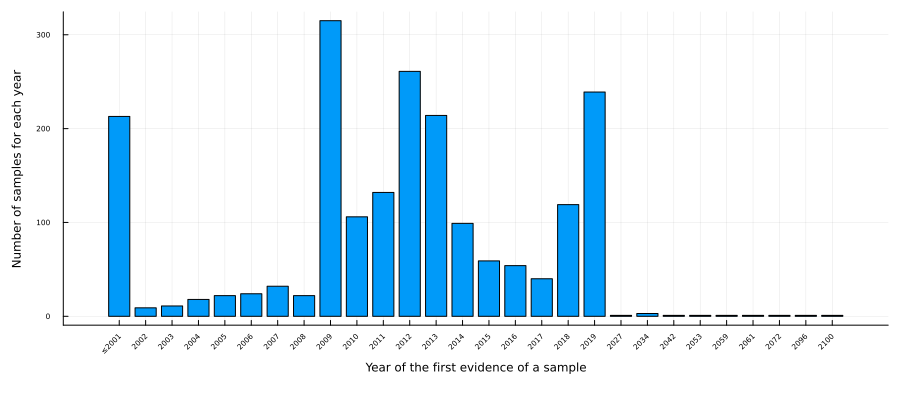

In [5]:
df_labels[!,:year] = map(i -> string(year(i)), df_labels.date) 
year_counts = sort(countmap(df_labels.year) |> collect, by = x -> x[1])
index = findfirst(j -> j[1] == "2001", year_counts)
previous_years = sum(map(j -> j[2], year_counts[1:index-1]))
year_counts[index] = Pair("≤"*year_counts[index][1], year_counts[index][2]+previous_years)
deleteat!(year_counts, 1:index-1)
bar(getindex.(year_counts,2), xticks=(1:length(year_counts), getindex.(year_counts,1)), xtickfontsize=5, ytickfontsize=5, xrotation=45, yguidefontsize=8, xguidefontsize=8, legend=false,
    xlabel="Year of the first evidence of a sample", ylabel="Number of samples for each year",size=(900,400),
    left_margin = 5Plots.mm, bottom_margin = 10Plots.mm)

In [6]:
@time begin
jsons = map(df_labels.name,df_labels.label) do n,y
    try 
        if y==1
            path=PATH_MAL_REPORTS
        elseif y==0
            path=PATH_BEN_REPORTS
        end
        x=open(JSON.parse, "$(path)$(n).json")
        #x=Dict("behavior" => Dict("apistats_opt" => x["behavior"]["apistats_opt"], "summary" => Dict("dll_loaded" => x["behavior"]["summary"]["dll_loaded"]) ))
        #delete!(x["behavior"],"apistats")  
        #delete!(x["behavior"],"apistats_opt")
        #x=x
    catch e
        @error "Error when processing sha $n: $e"
    end
end ;
end
n_samples=length(jsons)
println("N samples: $(n_samples)")
println("N labels: $(n_classes)")
@assert n_samples == length(df_labels.label)

 11.610939 seconds (12.40 M allocations: 902.532 MiB, 4.42% gc time, 3.08% compilation time)
N samples: 2000
N labels: 2


# Split train and test, and define the schema 

In [7]:
# Time-based split
#=
timesplit = Date(2013,8,9)
train_indexes = findall(i -> df_labels.date[i] < timesplit, 1:n_samples)
test_indexes = [setdiff(Set(1:n_samples), Set(train_indexes))...] ;

train_size = length(train_indexes)
test_size = length(test_indexes)

println("Train size: $(train_size)")
println("Test size: $(test_size)") =#


# Random split 
idx=shuffle(collect(1:n_samples))
tr_frac=0.8
train_indexes=idx[1:round(Int,tr_frac*n_samples)]
test_indexes=setdiff(idx,train_indexes)

train_size = length(train_indexes)
test_size = length(test_indexes)

println("Train size: $(train_size)")
println("Test size: $(test_size)")  

Train size: 1600
Test size: 400


In [8]:
chunks = Iterators.partition(train_indexes, div(train_size, THREADS))
sch_parts = tmap(chunks) do ch
    JsonGrinder.schema(jsons[ch])
end
complete_schema = merge(sch_parts...)
printtree(complete_schema)

[Dict] 	# updated = 1600
  ├──────────────── keys: [List] 	# updated = 1600
  │                         ╰── [Scalar - String], 1 unique values 	# updated = 1
  ├── imported_dll_count: [Scalar - Int64], 37 unique values 	# updated = 1600
  ├────── pe_versioninfo: [List] 	# updated = 1600
  │                         ╰── [Dict] 	# updated = 10558
  │                               ├── value: [Scalar - String], 3492 unique values 	# updated = 10558
  │                               ╰─── name: [Scalar - String], 70 unique values 	# updated = 10558
  ├─────────── signature: [Empty List] 	# updated = 1600
  │                         ╰── Nothing
  ├────────── pe_imphash: [Scalar - String], 1157 unique values 	# updated = 1600
  ├──────── pe_timestamp: [Scalar - String], 1199 unique values 	# updated = 1600
  ├──────── pe_resources: [List] 	# updated = 1600
  │                         ╰── [Dict] 	# updated = 37123
  │                               ├─────── offset: [Scalar - String], 5679 unique 

In [9]:
extractor=suggestextractor(complete_schema);
data=map(extractor,jsons);

┌ Warning: : key signature contains empty array, skipping
└ @ JsonGrinder C:\Users\aleca\.julia\packages\JsonGrinder\u8083\src\schema\dict.jl:61


In [10]:
data[1]

ProductNode 	# 1 obs, 424 bytes
  ├───── pdb_path: ArrayNode(2053×1 NGramMatrix with Union{Missing, Int64} ele ⋯
  ├─── pe_exports: BagNode 	# 1 obs, 120 bytes
  │                  ╰── ProductNode 	# 0 obs, 48 bytes
  │                        ┊
  ├───────── keys: BagNode 	# 1 obs, 80 bytes
  │                  ╰── ArrayNode(2×0 OneHotArray with Bool elements) 	# 0 ob ⋯
  ┊
  ├─── pe_imports: BagNode 	# 1 obs, 128 bytes
  │                  ╰── ProductNode 	# 1 obs, 56 bytes
  │                        ┊
  ╰── pe_sections: BagNode 	# 1 obs, 112 bytes
                     ╰── ProductNode 	# 3 obs, 40 bytes
                           ┊

# Define the model

In [11]:
labelnames = sort(unique(df_labels.label))
neurons = 32
model = reflectinmodel(complete_schema, extractor,
	k -> Dense(k, neurons, relu),
	d -> SegmentedMeanMax(d),
	fsm = Dict("" => k -> Dense(k, n_classes)),
)

minibatchsize = 100
function minibatch()
	idx = StatsBase.sample(train_indexes, minibatchsize, replace = false)
	reduce(catobs, data[idx]), Flux.onehotbatch(df_labels.label[idx], labelnames)
end

iterations = 200

function calculate_accuracy(x,y) 
    vals = tmap(x) do s
        Flux.onecold(softmax(model(s)), labelnames)[1]
    end
    mean(vals .== y)
end     
    

eval_trainset = shuffle(train_indexes)
eval_testset = shuffle(test_indexes)

cb = () -> begin
	train_acc = calculate_accuracy(data[eval_trainset], df_labels.label[eval_trainset])
	test_acc = calculate_accuracy(data[eval_testset], df_labels.label[eval_testset])
	println("accuracy: train = $train_acc, test = $test_acc")
end
ps = Flux.params(model)
loss = (x,y) -> Flux.logitcrossentropy(model(x), y)
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [12]:
epochs=1
for i in 1:epochs
    println("Epoch $(i)")
    Flux.Optimise.train!(loss, ps, repeatedly(minibatch, iterations), opt, cb = Flux.throttle(cb, 2))
end

Epoch 1
accuracy: train = 0.55125, test = 0.5375
accuracy: train = 0.944375, test = 0.9125
accuracy: train = 0.986875, test = 0.9425
accuracy: train = 0.99875, test = 0.955
accuracy: train = 0.998125, test = 0.965
accuracy: train = 0.999375, test = 0.965


# Accuracy and ROC curve

In [13]:
full_train_accuracy = calculate_accuracy(data[train_indexes], df_labels.label[train_indexes])
full_test_accuracy = calculate_accuracy(data[test_indexes], df_labels.label[test_indexes])
println("Final evaluation:")
println("Accuratcy on train data: $(full_train_accuracy)")
println("Accuratcy on test data: $(full_test_accuracy)")

Final evaluation:
Accuratcy on train data: 0.999375
Accuratcy on test data: 0.9675


AUC: 0.9944500000000001


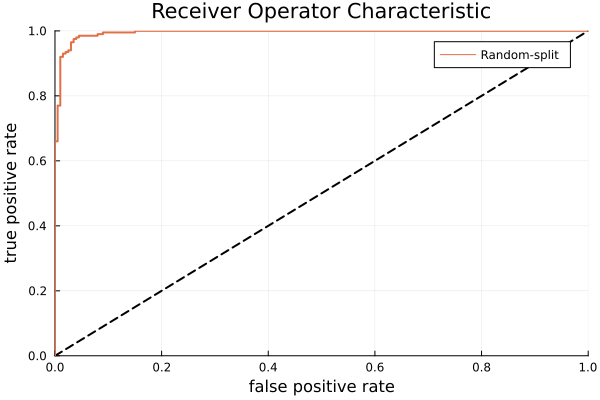

In [14]:
using ROC: roc,AUC

scores=softmax(model(data[test_indexes]))[2,:]
roc_curve = roc(scores, df_labels.label[test_indexes], true);

println("AUC: $(AUC(roc_curve))")
plot(roc_curve,lw=2,label="Random-split")
